# Validation for quantile delta change 

In [1]:
import sys

import xarray as xr
import cmocean

import validation
sys.path.append('/g/data/wp00/shared_code/qqscale')
import utils

In [2]:
# Parameters
adjustment_file = "/g/data/wp00/data/QQ-CMIP6/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/v20191115/pr-ssr-qdm-multiplicative-monthly-q100-adjustment-factors_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20560101-20851231_wrt_19950101-20141231.nc"
qq_file = "/g/data/wp00/data/QQ-CMIP6/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/v20191115/pr-ssr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_AUS-r005_20560101-20851231_qdm-multiplicative-monthly-q100-linear_AGCD-19900101-20191231_historical-19950101-20141231.nc"
hist_units = "mm day-1"
ref_units = "mm day-1"
target_units = "mm day-1"
output_units = "mm day-1"
hist_var = "pr"
ref_var = "pr"
target_var = "precip"
scaling = "multiplicative"
hist_files = "/g/data/wp00/data/QQ-CMIP6/ACCESS-ESM1-5/historical/r1i1p1f1/day/pr/v20191115/pr-ssr_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19950101-20141231.nc"
ref_files = "/g/data/wp00/data/QQ-CMIP6/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/pr/v20191115/pr-ssr_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20560101-20851231.nc"
target_files = "/g/data/wp00/data/AGCD/precip-ssr_AGCD_r005_19900101-20191231_daily.nc"
hist_time_bounds = "1995-01-01 2014-12-31"
ref_time_bounds = "2056-01-01 2085-12-31"
target_time_bounds = "1990-01-01 2019-12-31"

In [3]:
# Required parameters
assert 'scaling' in locals(), "Must provide the scaling method (option -p scaling {name})"
assert 'hist_var' in locals(), "Must provide an historical variable name (option -p hist_var {name})"
assert 'ref_var' in locals(), "Must provide a reference variable name (option -p ref_var {name})"
assert 'target_var' in locals(), "Must provide a target variable name (option -p target_var {name})"
assert 'hist_units' in locals(), "Must provide historical units (option -p hist_units {units})"
assert 'ref_units' in locals(), "Must provide reference units (option -p ref_units {units})"
assert 'target_units' in locals(), "Must provide target units (option -p target_units {units})"
assert 'output_units' in locals(), "Must provide output units (option -p output_units {units})"
assert 'adjustment_file' in locals(), "Must provide an adjustment factors file (option -p adjustment_file {file path})"
assert 'hist_files' in locals(), """Must provide historical data files (option -p hist_files {"file paths"})"""
assert 'ref_files' in locals(), """Must provide reference data files (option -p ref_files {"file paths"})"""
assert 'target_files' in locals(), """Must provide target data files (option -p target_files {"file paths"})"""
assert 'qq_file' in locals(), "Must provide an qq-scaled data file (option -p qq_file {file path})"
assert 'hist_time_bounds' in locals(), """Must provide time bounds for historical data (option -p hist_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'ref_time_bounds' in locals(), """Must provide time bounds for reference data (option -p ref_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""
assert 'target_time_bounds' in locals(), """Must provide time bounds for target data (option -p target_time_bounds {"YYYY-MM-DD YYYY-MM-DD"})"""

In [4]:
hist_files = hist_files.split()
ref_files = ref_files.split()
target_files = target_files.split()

hist_time_bounds = hist_time_bounds.split()
ref_time_bounds = ref_time_bounds.split()
target_time_bounds = target_time_bounds.split()

In [5]:
plot_config = {}
plot_config['pct_change_levels'] = [64, 72, 80, 88, 96, 104, 112, 120, 128, 136]
plot_config['pct_diff_levels'] = [-14, -10, -6, -2, 2, 6, 10, 14]
if hist_var == 'tasmin':
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [-1, 0.5, 2, 3.5, 5, 6.5, 8, 9.5, 11, 12.5, 14, 15.5, 17, 18.5, 20, 21.5]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
elif hist_var == 'tasmax':
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
elif hist_var == 'pr':
    plot_config['regular_cmap'] = cmocean.cm.rain
    plot_config['diverging_cmap'] = 'BrBG'
    plot_config['general_levels'] = [0, 0.01, 1, 2, 3, 4, 5, 7.5, 10, 15, 20, 25, 30, 40, 50, 60]
    plot_config['af_levels'] = [0.125, 0.25, 0.5, 0.67, 0.8, 1, 1.25, 1.5, 2, 4, 8]
    plot_config['difference_levels'] = [-0.55, -0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55]
else:
    raise ValueError(f'No plotting configuration defined for {hist_var}')

In [6]:
city_lat_lon = {
    'Hobart': (-42.9, 147.3),
    'Melbourne': (-37.8, 145.0),
    'Thredbo': (-36.5, 148.3),
    'Sydney': (-33.9, 151.2),
    'Brisbane': (-27.5, 153.0),
    'Cairns': (-16.9, 145.8),
    'Darwin': (-12.5, 130.8),
    'Alice Springs': (-23.7, 133.9),
    'Port Hedland': (-20.3, 118.6),
    'Perth': (-32.0, 115.9),
    'Adelaide': (-34.9, 138.6),
}

## Read data

In [7]:
ds_adjust = xr.open_dataset(adjustment_file)

In [8]:
ds_hist = utils.read_data(
    hist_files,
    hist_var,
    time_bounds=hist_time_bounds,
    input_units=hist_units,
    output_units=output_units,
)

In [9]:
ds_ref = utils.read_data(
    ref_files,
    ref_var,
    time_bounds=ref_time_bounds,
    input_units=ref_units,
    output_units=output_units,
)

In [10]:
ds_target = utils.read_data(
    target_files,
    target_var,
    time_bounds=target_time_bounds,
    input_units=target_units,
    output_units=output_units
)

In [11]:
ds_qq = xr.open_dataset(qq_file)

In [12]:
lat_min_qq = ds_qq['lat'].values.min()
lat_max_qq = ds_qq['lat'].values.max()
lon_min_qq = ds_qq['lon'].values.min()
lon_max_qq = ds_qq['lon'].values.max()

## Australia-wide

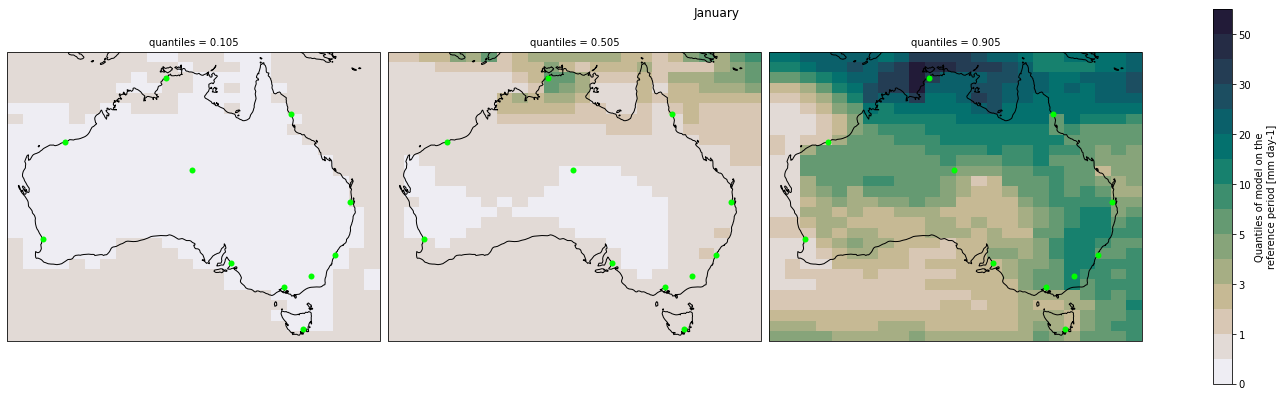

In [13]:
validation.quantile_spatial_plot(
    ds_adjust['hist_q'],
    1,
    plot_config['regular_cmap'],
    levels=plot_config['general_levels'],
    lat_bounds=[lat_min_qq, lat_max_qq],
    lon_bounds=[lon_min_qq, lon_max_qq],
    city_lat_lon=city_lat_lon,
)

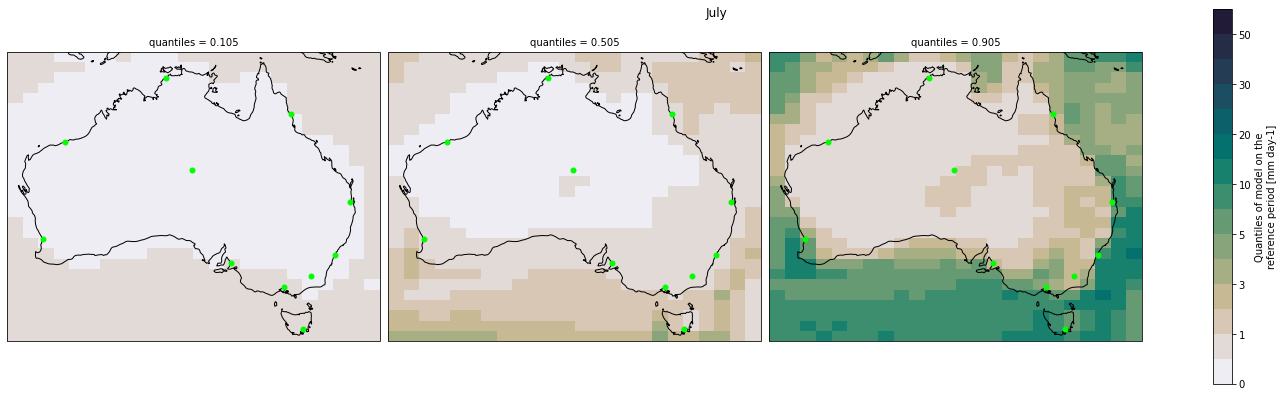

In [14]:
validation.quantile_spatial_plot(
    ds_adjust['hist_q'],
    7,
    plot_config['regular_cmap'],
    levels=plot_config['general_levels'],
    lat_bounds=[lat_min_qq, lat_max_qq],
    lon_bounds=[lon_min_qq, lon_max_qq],
    city_lat_lon=city_lat_lon,
)

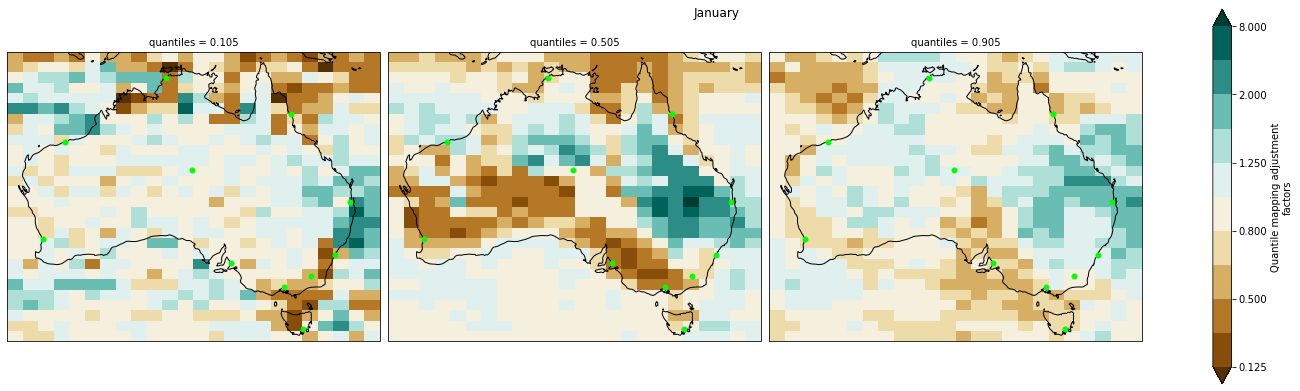

In [15]:
validation.quantile_spatial_plot(
    ds_adjust['af'],
    1,
    plot_config['diverging_cmap'],
    levels=plot_config['af_levels'],
    lat_bounds=[lat_min_qq, lat_max_qq],
    lon_bounds=[lon_min_qq, lon_max_qq],
    city_lat_lon=city_lat_lon,
)

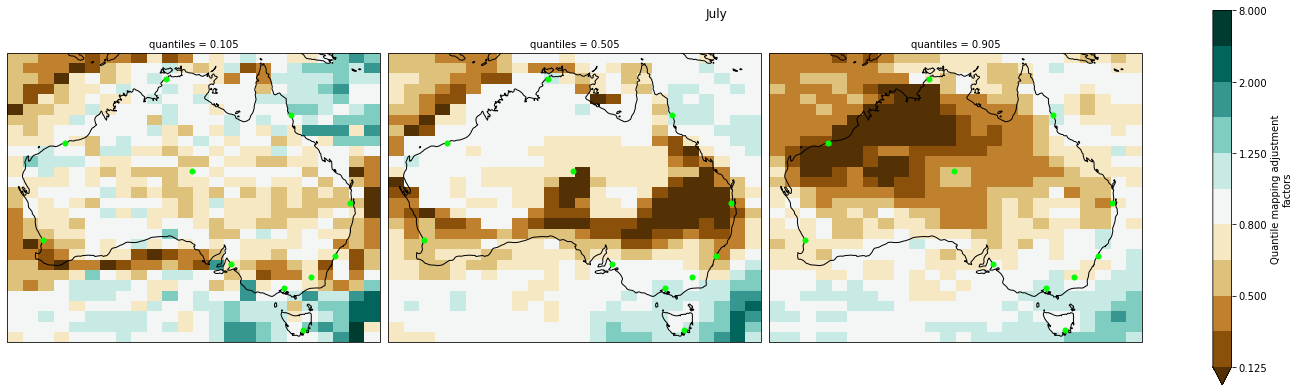

In [16]:
validation.quantile_spatial_plot(
    ds_adjust['af'],
    7,
    plot_config['diverging_cmap'],
    levels=plot_config['af_levels'],
    lat_bounds=[lat_min_qq, lat_max_qq],
    lon_bounds=[lon_min_qq, lon_max_qq],
    city_lat_lon=city_lat_lon,
)

In [ ]:
ref_hist_mean_comparison, qq_obs_mean_comparison = validation.projection_spatial_data(
    ds_hist[hist_var],
    ds_ref[ref_var],
    ds_target[target_var],
    ds_qq[target_var],
    scaling
)

In [ ]:
validation.projection_spatial_plot(
    ref_hist_mean_comparison,
    qq_obs_mean_comparison,
    plot_config['diverging_cmap'],
    plot_config['difference_levels'],
    city_lat_lon=city_lat_lon,
)

## Points of interest

In [ ]:
for city, coords in city_lat_lon.items():
    lat, lon = coords
    validation.single_point_analysis(
        ds_hist[hist_var],
        ds_ref[ref_var],
        ds_target[target_var],
        ds_qq[target_var],
        ds_adjust,
        city,
        lat,
        lon,
        months=[]
    )